<a href="https://colab.research.google.com/github/giyuhwang/waste_classification/blob/main/APS360_Team_3_Project_with_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APS360 Team 3 - Waste Classification Project

## Link to Github
Github Link: https://github.com/giyuhwang/waste_classification 

## Global Variables & Helper Functions

In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import time
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from google.colab import drive
from IPython.utils import path
import os

In [ ]:
# Mount google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Global Variables

In [ ]:
# Global variables
classes = ['containers_for_recycling', 'garbage', 'organics',
           'paper_coffee_cups', 'paper_for_recycling']
folder_path = '/content/gdrive/MyDrive/APS360 Fall 2022'
use_cuda = True

### Model Helper Functions

In [ ]:
########################################################################
def get_output_size(input, padding, kernel_size, stride):
  """ Compute output size after input passes a CNN layer
      Formula used: o = (i + 2p - k) / (s+1)
  """
  output = int((input + 2 * padding - kernel_size) / stride) + 1
  return output

########################################################################
def get_accuracy(net, loader):
  """ Compute accuracy of model using all dataset in loader
  """
  # Local variables
  correct = 0
  total = 0

  for images, labels in loader:
    # Use GPU accelerator if possible
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()

    # Forward pass
    outputs = net(images)

    # Count number of correct predictions
    pred = outputs.max(1, keepdim = True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += images.shape[0]  # Batch size
  
  # Compute average accuracy
  accuracy = correct / total
  return accuracy

########################################################################
def validate(net, loader, criterion):
  """ Evaluate the accuracy and loss of neural network with 
      validation dataset.

      Args:
        net: instance of neural network
        loader: validation dataset loader
        criterion: defined loss function. Should be same as training

      Returns:
        val_accuracy: average accuracy using validation dataset
        val_loss: average loss using validation dataset 
  """
  # Local variables
  total_loss = 0
  total_epoch = 0

  # Calculate average accuracy for validation dataset
  val_accuracy = get_accuracy(net, loader)

  # Calculate average loss for validation dataset
  for i, data in enumerate(loader, 0):
    images, labels = data

    # Use GPU accelerator if possible
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()

    outputs = net(images)
    loss = criterion(outputs, labels)
    total_loss += loss.item()

  val_loss = float(total_loss) / (i+1)

  return val_accuracy, val_loss

########################################################################
def print_acc_loss(epoch, num_epoch, train_acc, train_loss, val_acc, val_loss):
  """ Print report of accuracy and loss of model
  """
  print(('>> Epoch [{}/{}]: Train Accuracy: {:.4f}, Train Loss: {:.4f} | '
          'Validation Accuracy: {:.4f}, Validation Loss: {:4f}').format(
              epoch + 1,
              num_epoch,
              train_acc,
              train_loss,
              val_acc,
              val_loss))
  
########################################################################
def get_model_path(name, batch_size, lr, epoch):
  """ Get the path in google drive for a given model

      Args:
        name: name of the neural network (self.name)
        batch_size: size of batch
        lr: learning rate
        epoch: current or last number of epoch
  """
  sub_folder_path = ('Model')
  path = ('model_{0}_bs{1}_lr{2}_epoch{3}'.format(name,
                                                   batch_size,
                                                   lr,
                                                   epoch))
  return os.path.join(folder_path, sub_folder_path, path)

########################################################################
def plot_training_curve(path):
  """ Plot training and validation accuracy/loss given a csv file path

      Args:
        path: path of folder that contains csv files for accuracy/loss
  """
  # Retrieve data from csv files
  train_acc = np.loadtxt('{}_train_accuracy.csv'.format(path))
  val_acc = np.loadtxt('{}_validation_accuracy.csv'.format(path))
  train_loss = np.loadtxt("{}_train_loss.csv".format(path))
  val_loss = np.loadtxt("{}_validation_loss.csv".format(path))

  plt.title("Train vs Validation Accuracy")
  n = len(train_acc) # number of epochs
  plt.plot(range(1,n+1), train_acc, label="Train")
  plt.plot(range(1,n+1), val_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()
  plt.title("Train vs Validation Loss")
  plt.plot(range(1,n+1), train_loss, label="Train")
  plt.plot(range(1,n+1), val_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

### Dataset Helper Functions

In [ ]:
def get_data_loader(batch_size, num_workers = 0):
  """ Retrieve image dataset as dataloaders

      Args:
        batch_size: number of image samples per batch
        num_workers: number of sub-processes used for data loading
                     Default value is 0.

      Return:
        train_loader: iterable training dataset
        val_loader: iterable validation dataset
        test_loader: iterable testing dataset
  """
  # Get folder paths for train, validation, test dataset
  data_path = os.path.join(folder_path, 'Data')
  train_path = os.path.join(data_path, 'Training/')
  val_path = os.path.join(data_path, 'Validation')
  test_path = os.path.join(data_path, 'Testing')

  # Retrieve dataset from each folder
  transform = transforms.Compose([transforms.Resize((224,224)),
                                  transforms.ToTensor()])
  train_data = datasets.ImageFolder(train_path, transform = transform)
  val_data = datasets.ImageFolder(val_path, transform = transform)
  test_data = datasets.ImageFolder(test_path, transform = transform)
  
  # Construct data loaders based on retrieved dataset
  train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                             batch_size = batch_size,
                                             num_workers = num_workers, 
                                             shuffle = True)
  val_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                           batch_size = batch_size,
                                           num_workers = num_workers, 
                                           shuffle = True)
  test_loader = torch.utils.data.DataLoader(dataset = test_data, 
                                            batch_size = batch_size,
                                            num_workers = num_workers, 
                                            shuffle = True)
  
  return train_loader, val_loader, test_loader

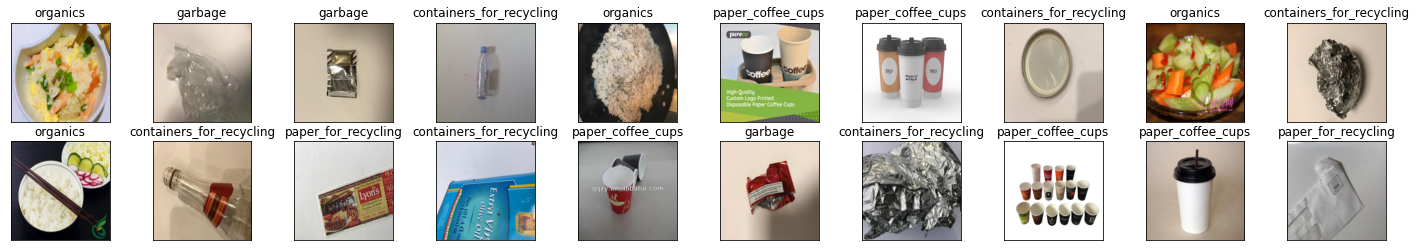

In [ ]:
#########################################################
# Visualize few sample images
train_loader, _, _ = get_data_loader(64)

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Primary Model

### Neural Network Definition

In [ ]:
class WasteNet(nn.Module):
  """ Class definition of waste classification neural network
      NOTE: input size is 224 * 224
  """
  #########################################################
  # Constructor
  def __init__(self, input_size, kernel_size):
    """ Constructor of model

        Args:
          input_size: dimension of input image (i.e. 224). 
                      Input image is assumed to be squared sized.
          
          kernel_size: dimension of kernel for convolutional layer. 
                       Kernel is assumed to be squared sized.
    """
    # Parent class constructor & name definition
    super(WasteNet, self).__init__()
    self.name = "Waste"

    # Local variables
    input_channels = 3
    cnn1_channels = 5
    cnn2_channels = 10
    fc1_size = 64
    num_classes = len(classes)

    # Define feature layers
    self.feature = nn.Sequential(
        nn.Conv2d(input_channels, cnn1_channels, kernel_size),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(cnn1_channels, cnn2_channels, kernel_size),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    # Compute output size after input passed all feature layers
    conv1_size = get_output_size(input_size, 0, kernel_size, 1)
    maxpool1_size = get_output_size(conv1_size, 0, 2, 2)
    conv2_size = get_output_size(maxpool1_size, 0, kernel_size, 1)
    maxpool2_size = get_output_size(conv2_size, 0, 2, 2)
    self.linear_size = maxpool2_size * maxpool2_size * cnn2_channels

    # Define classifier layers
    self.classifier = nn.Sequential(
        nn.Linear(self.linear_size, fc1_size),
        nn.Linear(fc1_size, num_classes)
    )
  

  #########################################################
  # Forward Pass
  def forward(self, img):
    """ Forward pass of model
    """
    feature = self.feature(img)
    feature_flatten = feature.view(-1, self.linear_size)
    output = self.classifier(feature_flatten)
    
    return output

### Model Training

In [ ]:
def train_net(net, batch_size = 64, lr = 0.001, num_epochs = 30):
  """ Train the model with training and validation dataset

      Args:
        net: instance of neural network
        batch_size: size of batch
        lr: learning rate
        num_epoch: total number of epochs
  """
  # Set fixed seed value for reproducable results
  torch.manual_seed(1000)

  #######################################################################
  # Retrieve train and validation datasets
  train_loader, val_loader, test_loader = get_data_loader(batch_size)

  #######################################################################
  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr = lr)

  #######################################################################
  # Local variables
  train_acc = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)

  #######################################################################
  # Train neural network
  
  # Initial setup
  start_time = time.time()
  print('===== Training Started ======')

  for epoch in range(num_epochs):
    total_train_loss = 0
    total_train_acc = 0

    # Iterate each batch of images
    for i, data in enumerate(train_loader, 0):
      # Retrieve inputs
      images, labels = data

      # Use GPU Accelerator if possible
      if use_cuda and torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()

      # Forward pass
      optimizer.zero_grad()   # Reset gradient
      outputs = net(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Track accumulated total loss
      total_train_loss += loss.item()

    # Compute average accuracy and loss for each epoch
    train_acc[epoch] = get_accuracy(net, train_loader)
    train_loss[epoch] = float(total_train_loss) / (i + 1)
    val_acc[epoch], val_loss[epoch] = validate(net, val_loader, criterion)

    # Report accuracy and loss results
    print_acc_loss(epoch, num_epochs, train_acc[epoch], train_loss[epoch],
                   val_acc[epoch], val_loss[epoch])
    
    # Save model checkpoint for each epoch
    model_path = get_model_path(net.name, batch_size, lr, epoch)
    torch.save(net.state_dict(), model_path)
  
  # Report total training time
  end_time = time.time()
  train_time = end_time - start_time
  print('===== Training Finished =====')
  print('===== Total train time: [{:.2f}s] ====='.format(train_time))

  # Save accuracy/loss results in csv files
  np.savetxt('{}_train_accuracy.csv'.format(model_path), train_acc)
  np.savetxt('{}_train_loss.csv'.format(model_path), train_loss)
  np.savetxt('{}_validation_accuracy.csv'.format(model_path), val_acc)
  np.savetxt('{}_validation_loss.csv'.format(model_path), val_acc)

In [ ]:
# Define hyperparameters
kernel_size = 3
batch_size = 64
learning_rate = 0.001
num_epoch = 30

# Create instance of model
my_net = WasteNet(224, kernel_size)

# Use GPU accelerator if possible
if use_cuda and torch.cuda.is_available():
  my_net.cuda()

train_net(my_net, batch_size, learning_rate, num_epoch)

===== Training Started ======


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


>> Epoch [1/30]: Train Accuracy: 0.3371, Train Loss: 2.1496 | Validation Accuracy: 0.3567, Validation Loss: 1.530398
>> Epoch [2/30]: Train Accuracy: 0.5429, Train Loss: 1.4261 | Validation Accuracy: 0.4333, Validation Loss: 1.410992
>> Epoch [3/30]: Train Accuracy: 0.6619, Train Loss: 1.2465 | Validation Accuracy: 0.5133, Validation Loss: 1.214708
>> Epoch [4/30]: Train Accuracy: 0.7333, Train Loss: 1.0155 | Validation Accuracy: 0.5667, Validation Loss: 1.089979
>> Epoch [5/30]: Train Accuracy: 0.7476, Train Loss: 0.8409 | Validation Accuracy: 0.5933, Validation Loss: 1.003754
>> Epoch [6/30]: Train Accuracy: 0.7724, Train Loss: 0.7366 | Validation Accuracy: 0.5733, Validation Loss: 1.024093
>> Epoch [7/30]: Train Accuracy: 0.8210, Train Loss: 0.6593 | Validation Accuracy: 0.5900, Validation Loss: 1.040776
>> Epoch [8/30]: Train Accuracy: 0.8619, Train Loss: 0.5545 | Validation Accuracy: 0.6267, Validation Loss: 0.965079
>> Epoch [9/30]: Train Accuracy: 0.7781, Train Loss: 0.5531 | Va

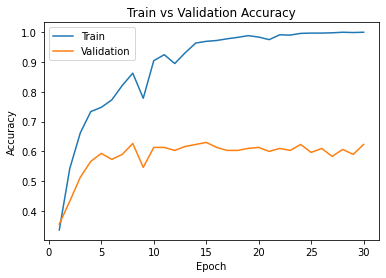

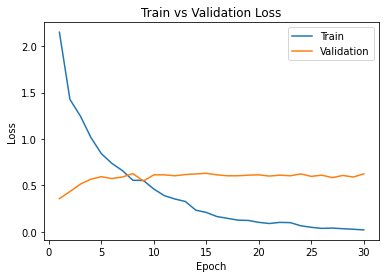

In [ ]:
# Plot training/validation curves
model_path = get_model_path(my_net.name, batch_size, learning_rate, num_epoch-1)
plot_training_curve(model_path)